# Task 2
You have a file containing data on purchases for last 3 months by weeks. Your task is to make a purchase prediction model for the next 3 months. Note that from 2020-02-02 to 2020-02-09 there was a special offer that increased sales by 7%.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf 

sns.set(style="whitegrid", rc={'figure.figsize':(12,6)})

In [2]:
# uploading a file and taking a look at the data
df = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Дата           14 non-null     object
 1   Число заказов  14 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 352.0+ bytes


In [4]:
df.rename(columns={'Дата':'date', 'Число заказов':'purchases'},inplace=True)
df.date = pd.to_datetime(df.date)
df

,date,purchases
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


The dataset is pretty small, so a simple prediction model should be enough. We could use a linear regression model here.

In [5]:
# fixing values to exclude the sales offer from the model
offer_sales = df.query('date == "2020-02-02"').purchases.div(1.07).round().astype(int)
df.loc[df['date'] == pd.to_datetime('2020-02-02'), 'purchases'] = offer_sales

In [6]:
df

,date,purchases
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1392
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


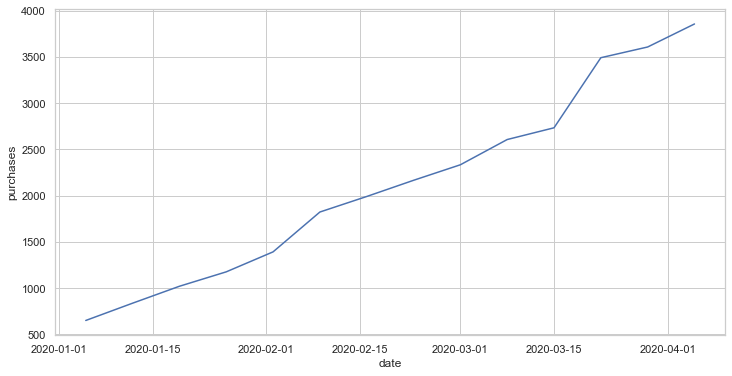

In [7]:
# making a plot to visualize data distribution
sns.lineplot(x=df.date, y=df.purchases)

In [8]:
# adding number of days for the model
df['days'] = pd.Series(df.date).diff().dt.days.fillna(0).astype(int).cumsum()

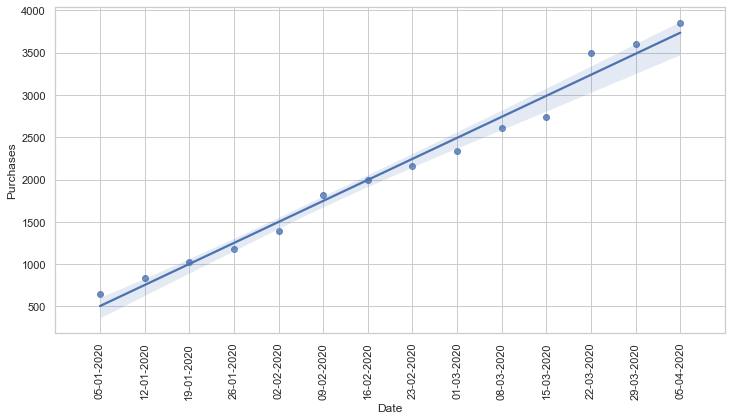

In [9]:
# making a linear plot
ax = sns.regplot(x='days', y='purchases', data=df)
plt.xticks(range(0, 98, 7))
x_labels = [(pd.to_datetime('2020-01-05') + pd.to_timedelta(i, unit='day')).strftime('%d-%m-%Y') for i in ax.get_xticks()]
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Purchases')
ax.set_xlim([-7, 98]);

In [10]:
# exploring correlation using Pearson and Spearman coefficients
st.pearsonr(df.days, df.purchases)

(0.9908872134593988, 8.107805614583336e-12)

In [11]:
st.spearmanr(df.days, df.purchases)

SpearmanrResult(correlation=1.0, pvalue=0.0)

We can see that there's a significant correlation. That means we can use a linear regression model.

In [12]:
st.linregress(df.days, df.purchases)

LinregressResult(slope=35.51302982731554, intercept=504.65714285714284, rvalue=0.9908872134593988, pvalue=8.10780561458332e-12, stderr=1.3935475952881082)

In [13]:
X = sm.add_constant(df.days)
model = sm.OLS(df.purchases, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              purchases   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     649.4
Date:                Sun, 08 Aug 2021   Prob (F-statistic):           8.11e-12
Time:                        17:58:10   Log-Likelihood:                -88.665
No. Observations:                  14   AIC:                             181.3
Df Residuals:                      12   BIC:                             182.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        504.6571     74.610      6.764      0.0

/Users/valentine/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


In [14]:
res.params

const    504.657143
days      35.513030
dtype: float64

**R-squared = 0.98**, that means the model corresponds to the data. This linear model can be described as function **y = 504.66 + 35.51\*x**, where y stands for number of purchases and x stands for number of days (starting from 2020-01-05). **P-value < 0.05**, so we can say the model's predictions are significant.

In [15]:
# making a sales prediction using the model
x = np.linspace(0, 189, 28)
x = sm.add_constant(x)
res.predict(x)

array([ 504.65714286,  753.24835165, 1001.83956044, 1250.43076923,
       1499.02197802, 1747.61318681, 1996.2043956 , 2244.7956044 ,
       2493.38681319, 2741.97802198, 2990.56923077, 3239.16043956,
       3487.75164835, 3736.34285714, 3984.93406593, 4233.52527473,
       4482.11648352, 4730.70769231, 4979.2989011 , 5227.89010989,
       5476.48131868, 5725.07252747, 5973.66373626, 6222.25494505,
       6470.84615385, 6719.43736264, 6968.02857143, 7216.61978022])

In [16]:
d = {'date': pd.date_range(pd.to_datetime('2020-01-05'), periods=28, freq='7d').tolist(),
     'pred_values': res.predict(x)}

In [17]:
df_model = pd.DataFrame(d)
df_model

,date,pred_values
0,2020-01-05,504.657143
1,2020-01-12,753.248352
2,2020-01-19,1001.839560
3,2020-01-26,1250.430769
4,2020-02-02,1499.021978
5,2020-02-09,1747.613187
6,2020-02-16,1996.204396
7,2020-02-23,2244.795604
8,2020-03-01,2493.386813
9,2020-03-08,2741.978022


In [18]:
# making a datafplot with original and predicted data
df_predict = df_model.iloc[14:].reset_index(drop=True)
df_predict['days'] = pd.Series(df_predict.date).diff().dt.days.fillna(98).astype('int').cumsum()
df_predict.rename(columns={'pred_values': 'purchases'}, inplace=True)
df['status'] = 'original'
df_predict['status'] = 'predicted'
df_total = pd.concat([df, df_predict]).reset_index(drop=True)
df_total

,date,purchases,days,status
0,2020-01-05,650.000000,0,original
1,2020-01-12,837.000000,7,original
2,2020-01-19,1020.000000,14,original
3,2020-01-26,1176.000000,21,original
4,2020-02-02,1392.000000,28,original
5,2020-02-09,1823.000000,35,original
6,2020-02-16,1991.000000,42,original
7,2020-02-23,2166.000000,49,original
8,2020-03-01,2334.000000,56,original
9,2020-03-08,2607.000000,63,original


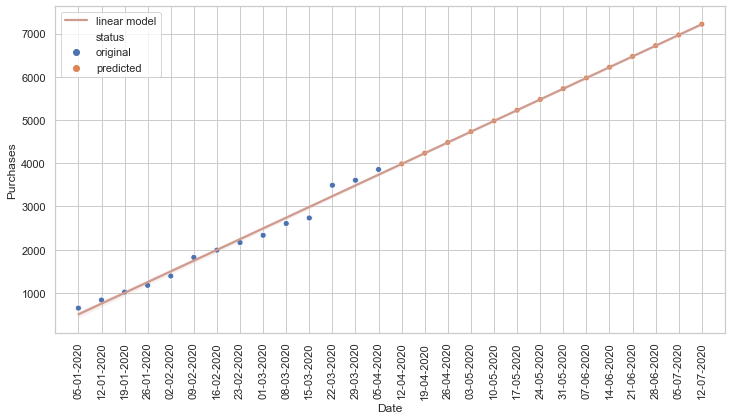

In [19]:
dotcolors = ['FF5733' if d > pd.to_datetime('2020-04-05') else '#338DFF' for d in df_total.date]
ax = sns.regplot(x='days', y='purchases', data=df_total, scatter_kws={"color": dotcolors},
                 line_kws={"color": '#CF9B8F'}, scatter=False, label='linear model')
sns.scatterplot(x='days', y='purchases', data=df_total, hue='status')

plt.xticks(range(0, 196, 7))
x_labels = [(pd.to_datetime('2020-01-05') + pd.to_timedelta(i, unit='day')).strftime('%d-%m-%Y') for i in ax.get_xticks()]
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Purchases')
ax.set_xlim([-7, 196])
plt.legend();

In [20]:
# adding a confidence interval
ci = res.conf_int(0.05)
print(ci)

                0           1
const  342.095641  667.218645
days    32.476750   38.549309


In [21]:
df_total['min_ci'] = ci[0][0] + df_total.days * ci[0][1]
df_total['max_ci'] = ci[1][0] + df_total.days * ci[1][1]
df_total

,date,purchases,days,status,min_ci,max_ci
0,2020-01-05,650.000000,0,original,342.095641,667.218645
1,2020-01-12,837.000000,7,original,569.432894,937.063809
2,2020-01-19,1020.000000,14,original,796.770147,1206.908974
3,2020-01-26,1176.000000,21,original,1024.107400,1476.754138
4,2020-02-02,1392.000000,28,original,1251.444653,1746.599303
5,2020-02-09,1823.000000,35,original,1478.781907,2016.444467
6,2020-02-16,1991.000000,42,original,1706.119160,2286.289631
7,2020-02-23,2166.000000,49,original,1933.456413,2556.134796
8,2020-03-01,2334.000000,56,original,2160.793666,2825.979960
9,2020-03-08,2607.000000,63,original,2388.130919,3095.825125


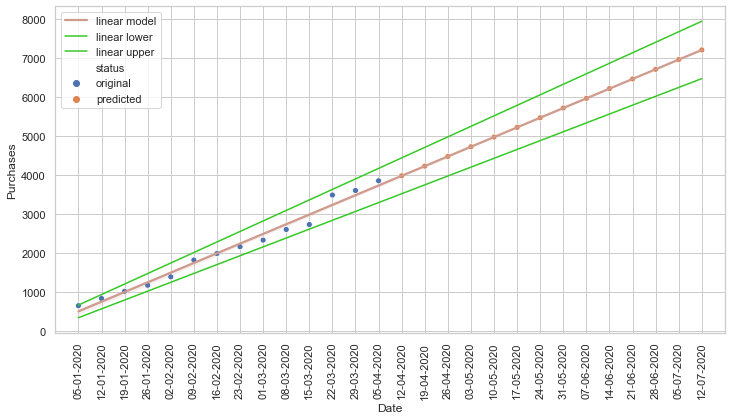

In [22]:
# making a plot with confidence intervals
dotcolors = ['FF5733' if d > pd.to_datetime('2020-04-05') else '#338DFF' for d in df_total.date]
ax = sns.regplot(x='days', y='purchases', data=df_total, scatter_kws={"color": dotcolors},
                 line_kws={"color": '#CF9B8F'}, scatter=False, label='linear model')
sns.scatterplot(x='days', y='purchases', data=df_total, hue='status')
sns.lineplot(x='days', y='min_ci', data=df_total, color='#34C924', label='linear lower')
sns.lineplot(x='days', y='max_ci', data=df_total, color='#34C924', label='linear upper')

plt.xticks(range(0, 196, 7))
x_labels = [(pd.to_datetime('2020-01-05') + pd.to_timedelta(i, unit='day')).strftime('%d-%m-%Y') for i in ax.get_xticks()]
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Purchases')
ax.set_xlim([-7, 196])
plt.legend();

All the data are within confidence intervals.

In [23]:
# making a result table with predicted data and confidence intervals
data_predicted = df_total.query('status == "predicted"')[['date', 'purchases', 'min_ci', 'max_ci']]
data_predicted[['purchases', 'min_ci', 'max_ci']] = (
    data_predicted[['purchases', 'min_ci', 'max_ci']].
    apply(lambda x: x.round().astype('int'),axis=1)
)
data_predicted.rename(columns={'min_ci':'min_purchases','max_ci':'max_purchases'},inplace=True)
data_predicted

,date,purchases,min_purchases,max_purchases
14,2020-04-12,3985,3525,4445
15,2020-04-19,4234,3752,4715
16,2020-04-26,4482,3979,4985
17,2020-05-03,4731,4207,5255
18,2020-05-10,4979,4434,5524
19,2020-05-17,5228,4662,5794
20,2020-05-24,5476,4889,6064
21,2020-05-31,5725,5116,6334
22,2020-06-07,5974,5344,6604
23,2020-06-14,6222,5571,6874
